# Recreating " Melanoma diagnosis using deep learning techniques on dermatoscopic images"

## Imports and Data Processing

### Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import multiprocessing
import torch.nn as nn
import numpy as np
#import torchvision
import torchvision.transforms.v2 as v2
from torchvision.utils import draw_bounding_boxes
from torch.utils.data import  DataLoader
from cjm_pytorch_utils.core import  move_data_to_device
from dataloader import ISICMaskImageDataset

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
device = torch.device(device)

from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights
weights = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT

Using cuda device


### Data Processing

In [2]:
#constants:
batch_size = 8
data_aug_type = "2" #what data augmentation schema to train on
dataset = "Dataset_2017"
#transforms = dataTransforms(data_aug_type)

Train_Dataset      = ISICMaskImageDataset(dataset,"Training",data_aug_type=data_aug_type)
Validation_Dataset = ISICMaskImageDataset(dataset,"Validation", data_aug_type="1") 
Test_Dataset       = ISICMaskImageDataset(dataset,"Test", data_aug_type="1") 

def collate_fn(batch):
    return tuple(zip(*batch))
data_loader_params = {
    'batch_size': batch_size,  # Batch size for data loading
    'num_workers': 0,  # Number of subprocesses to use for data loading
    'persistent_workers': False,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    'pin_memory': True,  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    'pin_memory_device': 'cuda' ,  # Specifies the device where the data should be loaded. Commonly set to use the GPU.
    'collate_fn':   collate_fn        #lambda batch: tuple(zip(*batch)),
}
data_loader_params_test = {
    'batch_size': batch_size,  # Batch size for data loading
    'num_workers': 0,  # Number of subprocesses to use for data loading
    'persistent_workers': False,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    'pin_memory': True,  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    'pin_memory_device': 'cuda' ,  # Specifies the device where the data should be loaded. Commonly set to use the GPU.
    'collate_fn':   collate_fn        #lambda batch: tuple(zip(*batch)),
}
train_dataloader      = DataLoader(Train_Dataset, **data_loader_params, shuffle=True)
validation_dataloader = DataLoader(Validation_Dataset, **data_loader_params, shuffle=True)
test_dataloader       = DataLoader(Test_Dataset, **data_loader_params_test, shuffle=False,in_order=True)

### Training function

In [3]:
def train_one_epoch(epoch_index, tb_writer, model, training_loader,optimizer,lr_scheduler,scaler,loss_fn):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, targets = data
        inputs = torch.stack(inputs)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        with torch.amp.autocast(torch.device(device).type):
            losses = model(inputs.to(device), move_data_to_device(targets, device))
            # Compute the loss and its gradients
            loss = (losses["loss_box_reg"]+ losses["loss_rpn_box_reg"])
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            old_scaler = scaler.get_scale()
            scaler.update()
            new_scaler = scaler.get_scale()
            if new_scaler >= old_scaler:
                lr_scheduler.step()
        else:
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
        #loss.backward()

        # Adjust learning weights
        #optimizer.step()

        # Gather data and report
        running_loss += loss
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

## R_CNN initialization

In [4]:
mask_model_train = True
mask_model_path = 'Trained_Models\\Mask-RCNN_Best_{}'.format(data_aug_type)
lr = 0.001
EPOCHS = 30
mask_model = maskrcnn_resnet50_fpn_v2(weights=weights, progress=False, trainable_backbone_layers=5, num_classes=None)
loss_fn = torch.nn.L1Loss()
#This code if training the model from scratch that I tested but fine tuning works better for us
'''
# Get the number of input features for the classifier
in_features_box = mask_model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = mask_model.roi_heads.mask_predictor.conv5_mask.in_channels
# Get the numbner of output channels for the Mask Predictor
dim_reduced = mask_model.roi_heads.mask_predictor.conv5_mask.out_channels
# Replace the box predictor
mask_model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=2)
# Replace the mask predictor
mask_model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=2)#
'''
optimizer = torch.optim.SGD(mask_model.parameters(), lr=lr,weight_decay=0.00001)
scaler = torch.amp.GradScaler("cuda")
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, total_steps=EPOCHS*len(train_dataloader))


In [5]:
# Initializing in a separate cell so we can easily add more epochs to the same run
if mask_model_train:
    #checkpoint = torch.load(mask_model_path)
    #mask_model.load_state_dict(checkpoint)
    mask_model.to(device)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('runs/Mask_RCNN{}'.format(timestamp))
    epoch_number = 0

    best_vloss = 1_000_000.

    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        mask_model.train(True)
        avg_loss = train_one_epoch(epoch_number, writer,mask_model,train_dataloader,optimizer,lr_scheduler,scaler,loss_fn)


        running_vloss = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        mask_model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(validation_dataloader):
                vinputs, vtargets = vdata
                vtargets = move_data_to_device(vtargets, device)
                with torch.amp.autocast(torch.device(device).type):
                    voutputs = mask_model(torch.stack(vinputs).to(device))
                    for j, vout in enumerate(voutputs):
                        vloss = loss_fn(vout["boxes"][vout["scores"].argmax(0).item()].unsqueeze(0), vtargets[j]["boxes"])
                        running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(mask_model.state_dict(), mask_model_path)

        epoch_number += 1


EPOCH 1:
  batch 100 loss: 0.039907071739435196
  batch 200 loss: 0.031018409878015518
LOSS train 0.031018409878015518 valid 316.5367736816406
EPOCH 2:
  batch 100 loss: 0.02639458328485489
  batch 200 loss: 0.024578042328357697
LOSS train 0.024578042328357697 valid 249.4842529296875
EPOCH 3:
  batch 100 loss: 0.024251261726021767
  batch 200 loss: 0.022903714329004288
LOSS train 0.022903714329004288 valid 183.9131622314453
EPOCH 4:
  batch 100 loss: 0.0221662987023592
  batch 200 loss: 0.021840989589691162
LOSS train 0.021840989589691162 valid 133.1311492919922
EPOCH 5:
  batch 100 loss: 0.020256876945495605
  batch 200 loss: 0.02010013349354267
LOSS train 0.02010013349354267 valid 119.85458374023438
EPOCH 6:
  batch 100 loss: 0.01868690364062786
  batch 200 loss: 0.018373562023043633
LOSS train 0.018373562023043633 valid 141.7435302734375
EPOCH 7:
  batch 100 loss: 0.016739845275878906
  batch 200 loss: 0.016618836671113968
LOSS train 0.016618836671113968 valid 144.1213836669922
EPOC

Here we can load our lowest loss model that we trained:

In [6]:
if not mask_model_train:
    checkpoint = torch.load(mask_model_path)
    mask_model.load_state_dict(checkpoint)
    mask_model.to(device)

Now we can load a picture and show the correct and predicted bounding boxes

In [7]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = v2.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
test_features, targets = next(iter(test_dataloader))
mask_model.eval()
with torch.amp.autocast(torch.device(device).type):
    pred_targets = mask_model(torch.stack(test_features).to(device))
#plt.imshow(img, cmap="rgb")


Red is the correct box and Blue is our predicted box


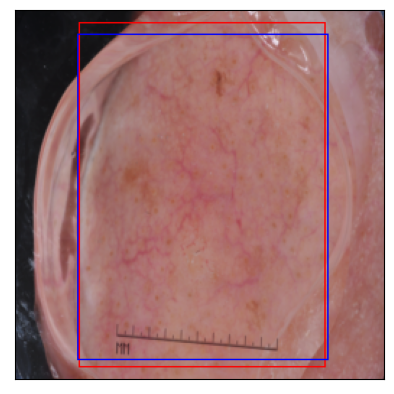

In [8]:
idx = 0
img = test_features[idx].squeeze()
label = targets[idx]["labels"]

correct_boxes = draw_bounding_boxes(img, torch.cat((targets[idx]["boxes"].to(device),pred_targets[idx]["boxes"][pred_targets[idx]["scores"].argmax(0).item()].unsqueeze(0))), colors=["red","blue"])
#Testing code below:
#print(torch.cat((targets[idx]["boxes"].to(device),pred_targets[idx]["boxes"][pred_targets[idx]["scores"].argmax().item()].unsqueeze(0))))
#print( pred_targets[idx]["boxes"][pred_targets[idx]["scores"].argmax().item()].unsqueeze(0) )
#correct_boxes = draw_bounding_boxes(img, targets[idx]["boxes"], colors="red")
#pred_boxes = draw_bounding_boxes(img, pred_targets[idx]["boxes"][pred_targets[idx]["scores"].argmax().item()].unsqueeze(0), colors="Blue")
#print(targets[idx]["boxes"])
#print(pred_targets[idx]["boxes"][0].unsqueeze(0))
show(correct_boxes)
#show(pred_boxes)
print("Red is the correct box and Blue is our predicted box")

## Testing the Model


In [9]:
running_tloss=0.0
with torch.no_grad():
    for i, tdata in enumerate(test_dataloader):
        tinputs, ttargets = tdata
        tinputs = torch.stack(tinputs).to(device)
        ttargets = move_data_to_device(ttargets, device)
        #again were using AMP to allow us to train faster
        with torch.amp.autocast(torch.device(device).type):
            outputs = mask_model(tinputs)
            for j, tout in enumerate(outputs):
                tloss = loss_fn(tout["boxes"][tout["scores"].argmax(0).item()].unsqueeze(0), ttargets[j]["boxes"])
                running_tloss += tloss
avg_tloss = running_tloss / (i + 1)
print('Test loss {}'.format(avg_tloss))


Test loss 147.11219787597656
